In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [4]:
imagenes = os.listdir('data')

In [6]:
imagenes[-3:]

['dog.9997.jpg', 'dog.9998.jpg', 'dog.9999.jpg']

In [7]:
ruta_imagenes = ['data/' + x for x in imagenes]

In [8]:
ruta_imagenes[:3]

['data/cat.0.jpg', 'data/cat.1.jpg', 'data/cat.10.jpg']

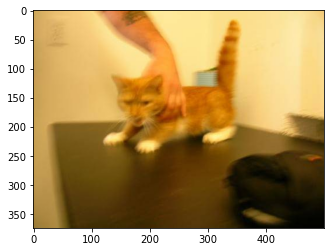

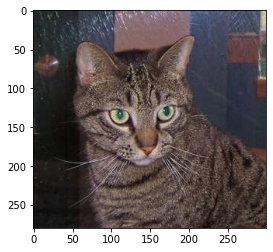

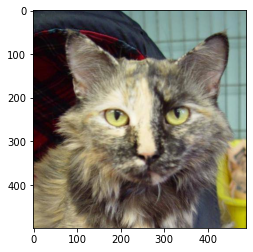

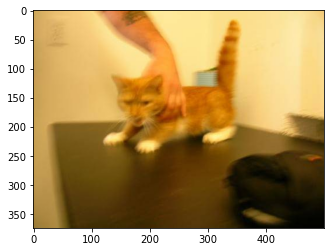

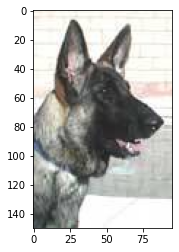

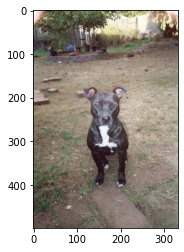

In [9]:
for i in range(3):
    img = imread(ruta_imagenes[i])
    plt.imshow(img)
    plt.show()
    
for i in range(3):
    img = imread(ruta_imagenes[-i])
    plt.imshow(img)
    plt.show()

In [10]:
n_muestras = 200
rutas_perros = [x for x in ruta_imagenes if 'dog' in x][:n_muestras]
rutas_gatos = [x for x in ruta_imagenes if 'cat' in x][:n_muestras]

In [11]:
rutas_perros[:3]

['data/dog.0.jpg', 'data/dog.1.jpg', 'data/dog.10.jpg']

In [12]:
rutas_gatos[:3]

['data/cat.0.jpg', 'data/cat.1.jpg', 'data/cat.10.jpg']

In [13]:
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image

Using TensorFlow backend.


In [15]:
imgs = list()
labels = list()

dim = 128

for i in range(n_muestras):
    img = load_img((rutas_perros[i]), target_size=(dim, dim),
                  grayscale=True)
    imgs.append(img_to_array(img))
    labels.append(1)
    
    img = load_img((rutas_gatos[i]), target_size=(dim, dim),
                  grayscale=True)
    imgs.append(img_to_array(img))
    labels.append(0)
    
array_imgs = np.asarray(imgs)
array_labels = np.asarray(labels)

In [20]:
def normalize_scale(image_data):
    scale_min = 0
    scale_max = 255
    return ((image_data - scale_min) / (scale_max - scale_min))

array_imgs_scale = normalize_scale(array_imgs)

In [24]:
array_imgs_scale.shape

(400, 128, 128, 1)

In [25]:
array_imgs_scale_v2 = array_imgs_scale.reshape(n_muestras*2,-1)\
.reshape(n_muestras*2, dim, dim)

In [26]:
array_imgs_scale_v2.shape

(400, 128, 128)

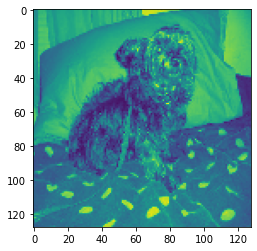

In [27]:
plt.imshow(array_imgs_scale_v2[0])
plt.show()

In [28]:
from sklearn.model_selection import train_test_split

In [30]:
X_fit, X_test, y_fit, y_test = train_test_split(array_imgs_scale,
                                                array_labels,
                                               test_size=0.4,
                                               random_state = 42)

X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                y_test,
                                               test_size=0.5,
                                               random_state = 42)

In [31]:
X_fit.shape, X_val.shape, X_test.shape

((240, 128, 128, 1), (80, 128, 128, 1), (80, 128, 128, 1))

In [32]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU

In [33]:
def define_model():
    model = Sequential()
    model.add(Conv2D(dim, (2,2), activation='relu',
                    kernel_initializer='he_uniform',
                    input_shape=(dim, dim, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (2,2), activation='relu',
                    kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(32, activation=PReLU()))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(lr=0.005)
    model.compile(optimizer=opt, loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

In [34]:
model = define_model()

c:\users\rodgo\appdata\local\programs\python\python36\lib\site-packages\keras\activations.py:235: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [35]:
callbacks = [EarlyStopping(monitor='val_accuracy',
                          patience=2,
                          restore_best_weights=True)]

In [36]:
history = model.fit(X_fit,
                    y_fit,
                    epochs = 20,
                    callbacks=callbacks,
                    verbose = 1,
                    batch_size=100,
                    validation_data=(X_val, y_val))

Train on 240 samples, validate on 80 samples
Epoch 1/20
240/240 [==============================] - 5s 22ms/step - loss: 1.8463 - accuracy: 0.5292 - val_loss: 0.6890 - val_accuracy: 0.5500
Epoch 2/20
240/240 [==============================] - 5s 21ms/step - loss: 0.7162 - accuracy: 0.5167 - val_loss: 0.6867 - val_accuracy: 0.5500
Epoch 3/20
240/240 [==============================] - 5s 21ms/step - loss: 0.6942 - accuracy: 0.5167 - val_loss: 0.6894 - val_accuracy: 0.5500


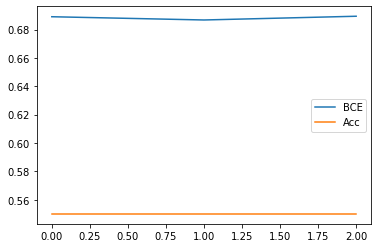

In [37]:
plt.plot(history.history['val_loss'], label='BCE')
plt.plot(history.history['val_accuracy'], label='Acc')
plt.legend()
plt.show()

In [38]:
y_preds = model.predict_classes(X_test)
y_preds[:3]

array([[1],
       [1],
       [1]])

In [39]:
y_preds = [x[0] for x in y_preds]
y_preds[:3]

[1, 1, 1]

In [40]:
from sklearn.metrics import accuracy_score

In [41]:
accuracy_score(y_true=y_test, y_pred=y_preds)

0.4